In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math

In [44]:
class KohonenNetwork:
    def __init__(self, M, N, input_dim, initial_sigma=1.0, sigma_decay=1.0, init_lr=0.1, decay_rate=100):
        # Inicjalizuje sieć z podanymi parametrami oraz przygotowuje wagi i mapę klastrów.
        self.M, self.N, self.input_dim = M, N, input_dim
        self.initial_sigma, self.sigma_decay = initial_sigma, sigma_decay
        self.init_lr, self.decay_rate = init_lr, decay_rate
        self.weights = np.random.rand(M, N, input_dim)
        self.bmu_cluster_map = np.zeros((M, N), dtype=int)

    def train(self, data, labels, epochs):
        # Prowadzi proces uczenia sieci przez zadana liczbę epok.
        for epoch in range(epochs):
            sigma = self.initial_sigma * np.exp(-epoch / self.decay_rate) * self.sigma_decay
            lr = self.init_lr * np.exp(-epoch / self.decay_rate)
            cluster_stats = {}
            for sample, label in zip(data, labels):
                bmu = self._find_bmu_and_update_weights(sample, sigma, lr)
                if bmu not in cluster_stats:
                    cluster_stats[bmu] = {}
                cluster_stats[bmu][label] = cluster_stats[bmu].get(label, 0) + 1
            for bmu, stats in cluster_stats.items():
                self.bmu_cluster_map[bmu] = max(stats, key=stats.get)

    def _find_bmu_and_update_weights(self, sample, sigma, lr):
        # Znajduje BMU, aktualizuje wagi i zwraca BMU.
        distances = np.linalg.norm(self.weights - sample, axis=2)
        bmu = np.unravel_index(np.argmin(distances), distances.shape)
        if sigma and lr:  # Ensure sigma and lr are not None before updating weights.
            for i in range(self.M):
                for j in range(self.N):
                    distance = np.linalg.norm(np.array([i, j]) - np.array(bmu))
                    self.weights[i, j] += lr * np.exp(-distance**2 / (2 * sigma**2)) * (sample - self.weights[i, j])
        return bmu

    def accuracy(self, data, labels):
        # Oblicza dokładność sieci na podstawie przypisania właściwych klastrów.
        correct = sum(self.bmu_cluster_map[self._find_bmu_and_update_weights(sample, None, None)] == label for sample, label in zip(data, labels))
        return 100 * correct / len(data) if data.size else 0
    
    def map_clusters(self, data, labels):
        # Mapuje klastry na podstawie danych wejściowych i etykiet.
        stats = {}
        for sample, label in zip(data, labels):
            bmu = self._find_bmu_and_update_weights(sample, None, None)  # Update weights not needed for just mapping
            if bmu not in stats:
                stats[bmu] = []
            stats[bmu].append(label)

        # Visualize the cluster data based on statistics.
        cluster_matrix = np.zeros((self.M, self.N))
        coverage_matrix = np.zeros((self.M, self.N))
        for (x, y), labels in stats.items():
            most_common = max(set(labels), key=labels.count)
            perc = 100 * labels.count(most_common) / len(labels)
            cluster_matrix[x, y] = most_common
            coverage_matrix[x, y] = perc
            print(f"BMU ({x}, {y}) predominantly represents cluster {most_common} with {perc:.2f}% coverage.")

        # Plotting the cluster data
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        cluster_display = axs[0].imshow(cluster_matrix, cmap='viridis', aspect='auto')
        axs[0].set(title='Dominujący Klaster na BMU', xlabel='Współrzędna X neuronu', ylabel='Współrzędna Y neuronu')
        fig.colorbar(cluster_display, ax=axs[0], orientation='vertical')
        coverage_display = axs[1].imshow(coverage_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=100)
        axs[1].set(title='Pokrycie Dominującego Klastra na BMU', xlabel='Współrzędna X neuronu', ylabel='Współrzędna Y neuronu')
        fig.colorbar(coverage_display, ax=axs[1], orientation='vertical')
        plt.tight_layout()
        plt.show()

    def visualize_clusters(self, data):
        # Wizualizuje klastry na podstawie danych wejściowych.
        clusters = [self.bmu_cluster_map[self._find_bmu_and_update_weights(sample, None, None)] for sample in data]
        fig = plt.figure()
        if data.shape[1] == 3:
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=clusters, cmap='viridis', edgecolors='k', s=50)
            ax.set_title('Dane sklastrowane 3D')
            ax.set_xlabel('Wymiar 1')
            ax.set_ylabel('Wymiar 2')
            ax.set_zlabel('Wymiar 3')
        else:
            ax = fig.add_subplot(111)
            scatter = ax.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', edgecolors='k', s=50)
            ax.set_title('Dane sklastrowane 2D')
            ax.set_xlabel('Wymiar 1')
            ax.set_ylabel('Wymiar 2')
        plt.colorbar(scatter, label='Klaster')
        plt.show()


In [45]:
hexagon = pd.read_csv('../data/hexagon.csv').values
cube = pd.read_csv('../data/cube.csv').values

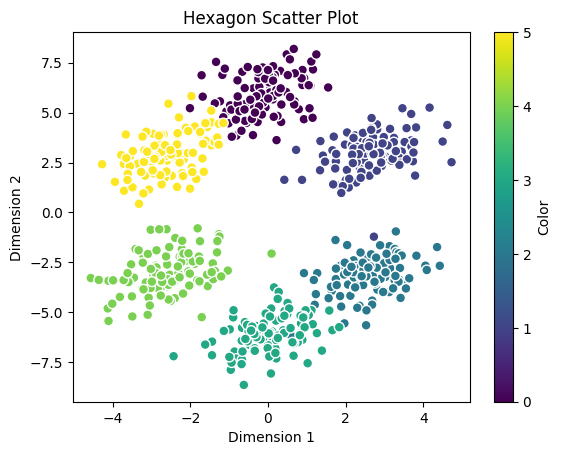

In [46]:
plt.scatter(hexagon[:, 0], hexagon[:, 1], c=hexagon[:, 2], cmap='viridis', edgecolors='w', s=50)
plt.title('Hexagon Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Color')
plt.show()


In [47]:
data_hex = pd.read_csv('../data/hexagon.csv').values[:, :2]
data_cube = pd.read_csv('../data/cube.csv').values[:, :3]

In [48]:
labels_hex = pd.read_csv('../data/hexagon.csv').values[:, -1]
labels_cube = pd.read_csv('../data/cube.csv').values[:, -1]

In [49]:
unique_labels = np.unique(labels_hex)
print(unique_labels)


[0. 1. 2. 3. 4. 5.]


In [50]:
network = KohonenNetwork(M=10, N=10, input_dim=2, initial_sigma=1.0, sigma_decay=0.1, init_lr=0.10, decay_rate=100)

In [51]:
network.train(data_hex, labels_hex, 10)

In [52]:
accuracy = network.accuracy(data_hex, labels_hex)
print(f"Cluster accuracy: {accuracy:.2f}%")

Cluster accuracy: 93.83%


BMU (1, 0) predominantly represents cluster 1.0 with 90.00% coverage.
BMU (6, 0) predominantly represents cluster 0.0 with 93.20% coverage.
BMU (6, 5) predominantly represents cluster 2.0 with 98.70% coverage.
BMU (1, 7) predominantly represents cluster 1.0 with 100.00% coverage.
BMU (6, 4) predominantly represents cluster 4.0 with 100.00% coverage.
BMU (8, 8) predominantly represents cluster 4.0 with 100.00% coverage.
BMU (6, 7) predominantly represents cluster 3.0 with 97.50% coverage.
BMU (4, 0) predominantly represents cluster 1.0 with 100.00% coverage.
BMU (7, 6) predominantly represents cluster 5.0 with 98.94% coverage.
BMU (7, 8) predominantly represents cluster 1.0 with 100.00% coverage.
BMU (0, 2) predominantly represents cluster 2.0 with 50.00% coverage.
BMU (2, 1) predominantly represents cluster 2.0 with 50.00% coverage.
BMU (3, 3) predominantly represents cluster 1.0 with 100.00% coverage.
BMU (6, 2) predominantly represents cluster 1.0 with 100.00% coverage.


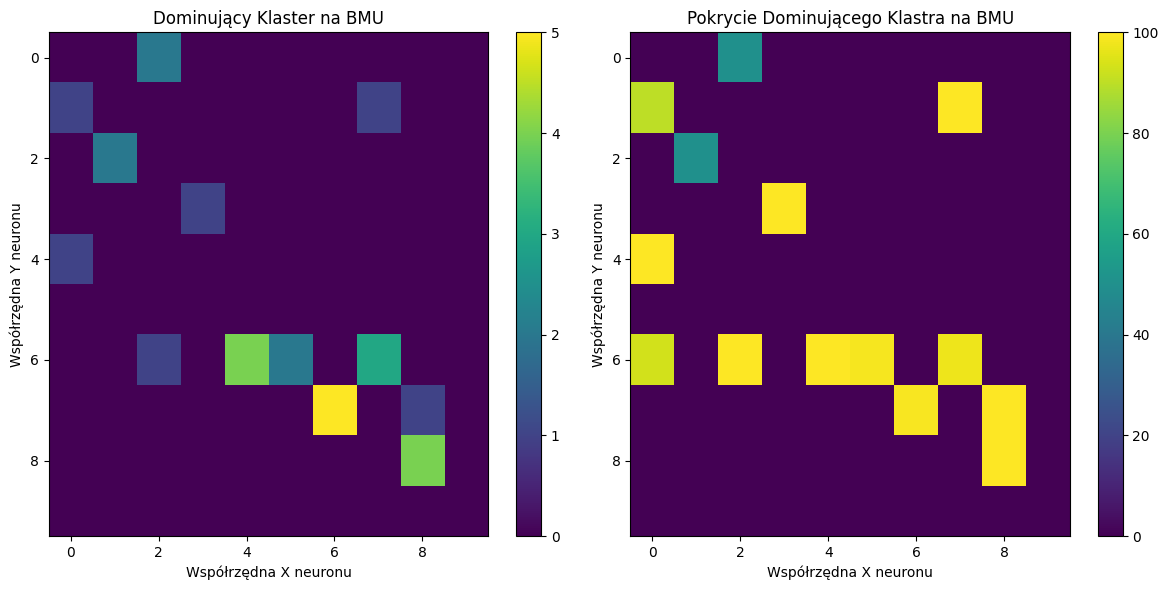

In [53]:
network.map_clusters(data_hex, labels_hex)

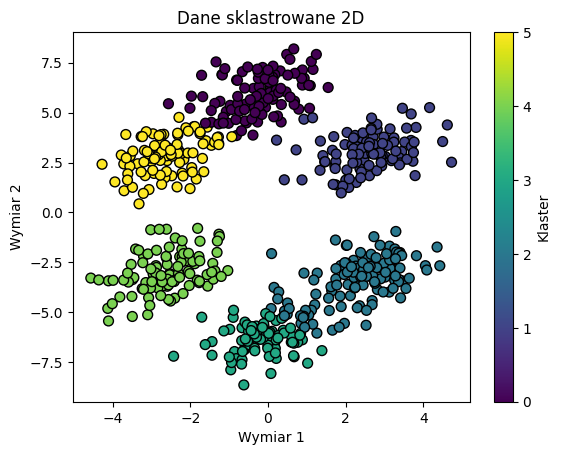

In [54]:
network.visualize_clusters(data_hex)

In [55]:
network2 = KohonenNetwork(M=3, N=2, input_dim=2, initial_sigma=1.0, sigma_decay=0.1, init_lr=3, decay_rate=100)


In [56]:
network2.train(data_hex, labels_hex, 10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_57619/2928578906.py:32: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += lr * np.exp(-distance**2 / (2 * sigma**2)) * (sample - self.weights[i, j])
/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_57619/2928578906.py:32: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += lr * np.exp(-distance**2 / (2 * sigma**2)) * (sample - self.weights[i, j])


In [57]:
accuracy2 = network2.accuracy(data_hex, labels_hex)
print(f"Cluster accuracy: {accuracy2:.2f}%")

Cluster accuracy: 16.67%


BMU (0, 0) predominantly represents cluster 0.0 with 16.67% coverage.


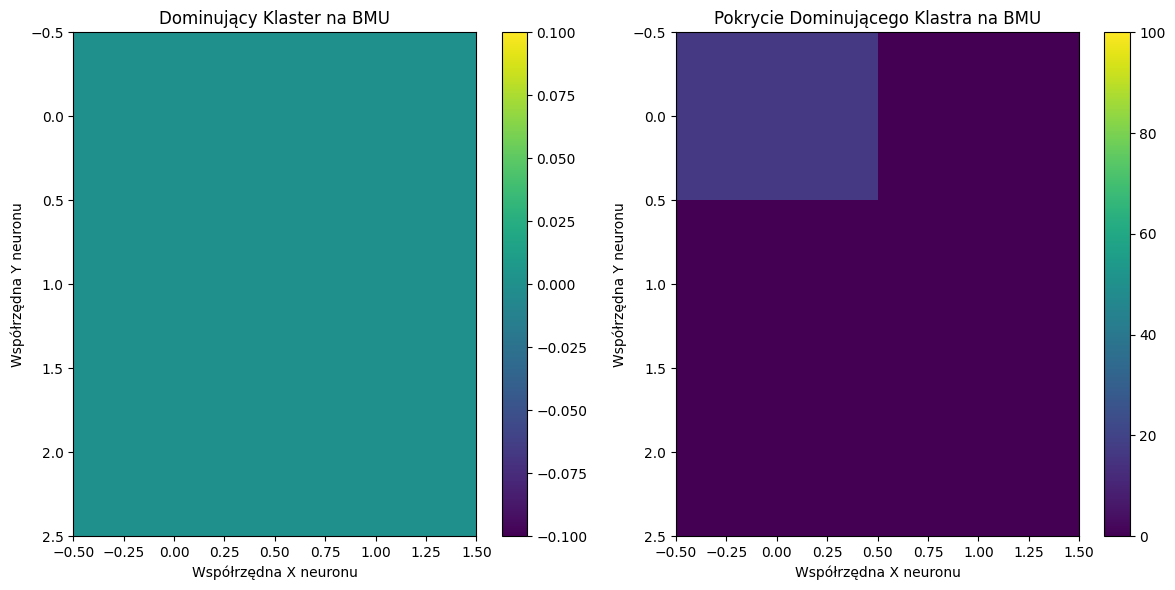

In [58]:
network2.map_clusters(data_hex, labels_hex)

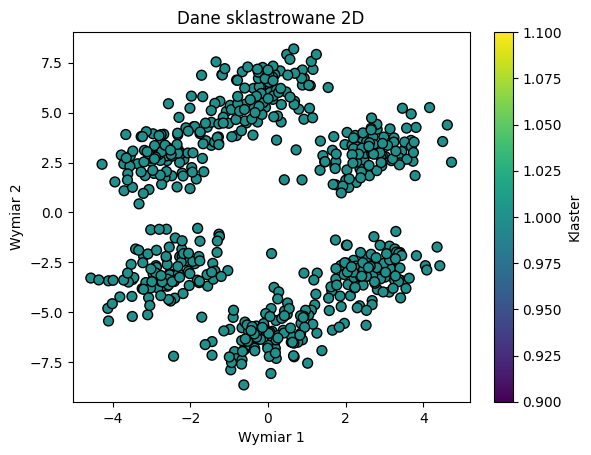

In [59]:
network2.visualize_clusters(data_hex)